# Knowledge Distillation for Unsupervised Anomaly Detection


This notebook demonstrates knowledge distillation for unsupervised anomaly detection.

We draw inspiration from the paper [Student-Teacher Feature Pyramid Matching for Anomaly Detection](https://arxiv.org/pdf/2103.04257) and its [associated code](https://github.com/xiahaifeng1995/STPM-Anomaly-Detection-Localization-master). The figure below, taken from the paper, illustrates how the method works:

![stpm](./images/stpm.png)


## Choosing the Backbone and Dataset


### Backbone and Loss Function


The paper uses [ResNet18](https://arxiv.org/pdf/1512.03385) as the network architecture, with the *teacher* model pre-trained on [ImageNet](https://www.image-net.org/). The *student* uses the same architecture, but its network is randomly initialized.

As shown in the figure above, the loss function is calculated on the outputs of the first three layer groups of ResNet18. A layer group corresponds to the set of layers operating at the same image resolution. The *student* network is thus trained to replicate the *feature maps* of the *teacher* network only at these three outputs. The anomaly score is also calculated on these outputs.

The loss function used is simply the MSE *loss*, which we have seen before. This *loss* is calculated on each *feature map*, then summed to obtain the total *loss*.


### Dataset


The dataset used in the paper is [MVTEC AD](https://www.mvtec.com/company/research/datasets/mvtec-ad). It contains 15 categories, including 10 objects and 5 textures. Each category includes approximately 350 defect-free images for training and about 100 defective images for testing.

Here is a preview of the dataset images:

![mvtec](./images/mvtec.png)

You can download the dataset [here](https://www.mvtec.com/company/research/datasets/mvtec-ad). For our implementation, we will use the *hazelnut* category.


## Implementation with PyTorch and timm


Some functions are a bit complex and not essential to understand the concept (loading the dataset, etc.). For clarity, these functions and classes have been moved to the utils.py file, which you can consult if needed.


In [1]:
import matplotlib.pyplot as plt
from utils import MVTecDataset,cal_anomaly_maps
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset


Let's start by loading the dataset and taking a look at its contents.
This time, we will properly separate the training into two parts: training and validation, so that we can evaluate the model during training.


In [2]:
train_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/train/good",resize_shape=[256,256],phase='train')
test_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/test/",resize_shape=[256,256],phase='test')
print("taille du dataset d'entrainement : ",len(train_dataset))
print("taille du dataset de test : ",len(test_dataset))
print("taille d'une image : ",train_dataset[0]['imageBase'].shape)

# Séparation du dataset d'entrainement en train et validation
img_nums = len(train_dataset)
valid_num = int(img_nums * 0.2)
train_num = img_nums - valid_num
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

# Création des dataloaders
train_loader=torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


taille du dataset d'entrainement :  391
taille du dataset de test :  110
taille d'une image :  (3, 256, 256)


We can visualize some defects:


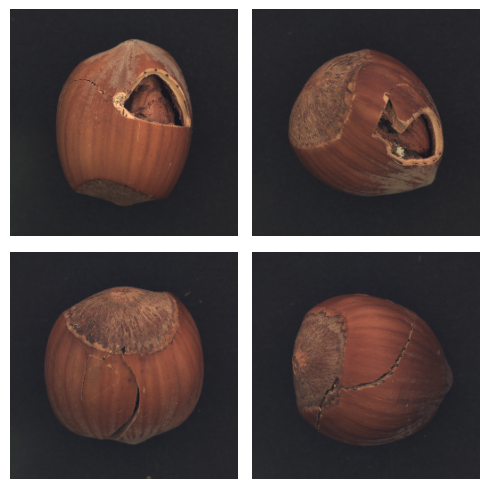

In [3]:
num_defects_displayed = 0
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

for sample in test_loader:
  image = sample['imageBase']
  has_defect = sample['has_anomaly']
  if has_defect:
    row = num_defects_displayed // 2
    col = num_defects_displayed % 2
    
    axes[row, col].imshow(image.squeeze().permute(1, 2, 0).numpy())
    axes[row, col].axis('off')  
    
    num_defects_displayed += 1
    
    if num_defects_displayed == 4:
      break
plt.tight_layout()
plt.show()

### Creating the Teacher and Student Models


For our models, we will use the same class and specify the specifics of each model as parameters.
To facilitate the use of an existing *backbone*, we use the [timm](https://timm.fast.ai/) library (*PyTorch Image Models*). This is a very interesting library for accessing *backbones* and pre-trained models. It also offers some flexibility to manipulate the network.


In [4]:
class resnet18timm(nn.Module):
    def __init__(self,backbone_name="resnet18",out_indices=[1,2,3],pretrained=True):
        super(resnet18timm, self).__init__()     
        # Features only permet permet de ne récupérer que les features et pas la sortie du réseau, out_indices permet de choisir les couches à récupérer
        self.feature_extractor = timm.create_model(backbone_name,pretrained=pretrained,features_only=True,out_indices=out_indices)
        if pretrained:
            # Si le modèle est pré-entrainé (donc c'est le teacher), on gèle les poids
            self.feature_extractor.eval() 
            for param in self.feature_extractor.parameters():
                param.requires_grad = False   
        
    def forward(self, x):
        features = self.feature_extractor(x)
        return features

We can now create our *teacher* and *student*:


In [5]:
student=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=False).to(device)
teacher=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=True).to(device)

### Loss Function


The loss function uses the Euclidean distance (MSE), defined as follows:
$D(I_1, I_2) = \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n} \left( I_1(i,j) - I_2(i,j) \right)^2}$ where $I_1$ and $I_2$ are our two images.

Our implementation of the loss uses this distance to compare the *feature maps* for the 3 pairs of *feature maps*:


In [6]:
class loss_kdad:
  def __init__(self):
    pass
  # fs_list : liste des features du student et ft_list : liste des features du teacher
  def __call__(self,fs_list, ft_list):
    t_loss = 0
    N = len(fs_list)
    for i in range(N):
      fs = fs_list[i]
      ft = ft_list[i]
      _, _, h, w = fs.shape
      # Normaliser les features améliore les résultats
      fs_norm = F.normalize(fs, p=2)
      ft_norm = F.normalize(ft, p=2)

      # Calcul de la distance euclidienne
      f_loss = 0.5 * (ft_norm - fs_norm) ** 2
      # On prend la moyenne de la loss sur tous les pixels
      f_loss = f_loss.sum() / (h * w)
      t_loss += f_loss

    return t_loss / N

### Model Training


Let's define our hyperparameters:


In [7]:
epochs= 20
lr=0.0004
criterion = loss_kdad()
optimizer = torch.optim.Adam(student.parameters(), lr=lr)

It's time to train the model! Training may take some time.


In [8]:
for epoch in range(epochs):
    student.train()
    train_loss = 0.0
    for data in train_loader:
        image = data['imageBase'].to(device)
        optimizer.zero_grad()
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    student.eval()
    val_loss = 0.0
    for data in val_loader:
        image = data['imageBase'].to(device)
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        val_loss += loss.item()
    print("Epoch {} - train loss : {} - val loss : {}".format(epoch,train_loss/len(train_loader),val_loss/len(val_loader)))

Epoch 0 - train loss : 1.6731480107277255 - val loss : 1.3833315640687942
Epoch 1 - train loss : 0.8773692731238618 - val loss : 0.7371394574642182
Epoch 2 - train loss : 0.5567233881241158 - val loss : 0.5115290269255638
Epoch 3 - train loss : 0.4170471341172351 - val loss : 0.4163943402469158
Epoch 4 - train loss : 0.33714089627507365 - val loss : 0.3523293524980545
Epoch 5 - train loss : 0.29374887162371527 - val loss : 0.28786116763949393
Epoch 6 - train loss : 0.2577011583349373 - val loss : 0.2747397504746914
Epoch 7 - train loss : 0.2373752082827725 - val loss : 0.22077917009592057
Epoch 8 - train loss : 0.21801123603046696 - val loss : 0.2255100306123495
Epoch 9 - train loss : 0.2012799475577813 - val loss : 0.19499738812446593
Epoch 10 - train loss : 0.1874875887473927 - val loss : 0.20737174898386002
Epoch 11 - train loss : 0.17415884736029408 - val loss : 0.254209216684103
Epoch 12 - train loss : 0.16137944416532032 - val loss : 0.15532575249671937
Epoch 13 - train loss : 0.

We can now evaluate our model. For this, we use the AUROC measure (see [course 9](../09_EntrainementContrastif/01_FaceVerification.ipynb) for a reminder).


In [11]:
scores = []
test_imgs = []
gt_list = []
for sample in test_loader:
    label=sample['has_anomaly']
    image = sample['imageBase'].to(device)
    test_imgs.extend(image.cpu())
    gt_list.extend(label.cpu().numpy())
    with torch.set_grad_enabled(False):
        
        outputs_student = student(image)
        outputs_teacher = teacher(image) 

        # La fonction cal_anomaly_maps permet de calculer la carte d'anomalie (ça sera utile pour la visualisation après)
        score =cal_anomaly_maps(outputs_student,outputs_teacher,256) 
        
    scores.append(score)
scores = np.asarray(scores)
gt_list = np.asarray(gt_list)

from sklearn.metrics import roc_auc_score

map_scores = np.asarray(scores)

max_anomaly_score = map_scores.max()
min_anomaly_score = map_scores.min()
map_scores = (map_scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)
img_scores = map_scores.reshape(map_scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
img_roc_auc = roc_auc_score(gt_list, img_scores)
print(" image hazelnut ROCAUC : %.3f" % (img_roc_auc))


 image hazelnut ROCAUC : 0.990


We achieve a very good AUROC, our model is very good at detecting defects on hazelnuts.


### Visualizing the Anomaly Map


To calculate the score, we compared the *feature maps* of the *teacher* to those of the *student* on the 3 outputs (of different dimensions). Using the *cal_anomaly_maps* function, we performed the comparisons and reconstructed an anomaly map the size of the original image. We can visualize this anomaly map to obtain a localization of the defect.


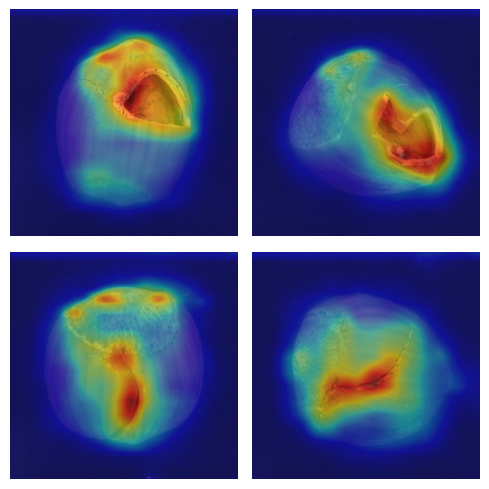

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

for i,(img,mask) in enumerate(zip(test_imgs,scores)):
    img_act=img.squeeze().permute(1, 2, 0).numpy()
    row = i // 2
    col = i % 2
    axs[row, col].imshow(img_act) 
    axs[row, col].imshow(mask, cmap='jet', alpha=0.5)
    axs[row, col].axis('off')
    if i==3:
        break
    
plt.tight_layout()
plt.show()


We observe that the localization is quite precise, although this is not the primary goal of our model.
